In [39]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display

import IPython.display

Dataset explored is UrbanSound8K:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

https://urbansounddataset.weebly.com/urbansound8k.html

https://zenodo.org/record/1203745

In [2]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.info()
display(metadata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [3]:
# Simple way to have a dict relating classID to class
class_dict = {}
for index, row in metadata.iterrows():
    class_dict[row['classID']]=row['class']
print(class_dict)
print(f'Number of unique classes: {len(class_dict)}')

{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
Number of unique classes: 10


In [4]:
# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename)

In [99]:
# Function to get various visualizations for a data row
def visualize_data(row):
    
    print(f'Class: {row["class"]}')
    print(f'Duration: {round(row["end"]-row["start"],3)}s')
    print(f'Salience: {"foreground" if row["salience"]==1 else "background"}')
    y,sr = load_data(row)

    # Allow audio playback, but rescale amplitude so that I don't need to manually lower volume for each visualized datum
    max_amp = max(abs(y))
    y_norm = np.copy(y)/(max_amp*10)
    display(IPython.display.Audio(data=y_norm, rate=sr, normalize=False))
    
    # Mostly equivalent to plt.plot(y)
    librosa.display.waveshow(y,sr=sr)
    plt.title('Waveform')
    plt.show()
    
    # Fourier transform
    yF = np.abs(np.fft.fft(y))
    plt.plot(yF[:len(yF)//2])
    plt.title('Fourier Transform')
    plt.show()
    
    # Short-Time Fourier transform, basically calculate the fourier transform of consecutive small time windows, giving a 2D function as output
    ySF = np.abs(librosa.stft(y, n_fft=512))
    librosa.display.specshow(ySF, x_axis='time', y_axis='linear')
    plt.colorbar()
    plt.title('Short-Time Fourier Transform')
    plt.show()
    S_db = librosa.amplitude_to_db(ySF, ref=np.max) # Converting to decibell is effectively just a logarithmic transform 
    librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
    plt.colorbar()
    plt.title('Logarithmic Short-Time Fourier Transform')
    plt.show()
    
    # 'Cepstrum' spectrogram. Apparently these are used often in audio analysis. I'm still reading up on why this particular transform is considered useful.
    # 'Mel-frequency' refers to a transform of frequency that makes it more akin to the human melodic hearing range, which is probably not necessary for gunshot detection.
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    librosa.display.specshow(mfcc, x_axis='time', y_axis='linear')
    plt.colorbar()
    plt.title('Mel-frequency cepstral coefficients (MFCCs)')
    plt.show()
    

Class: dog_bark
Duration: 3.1s
Salience: background


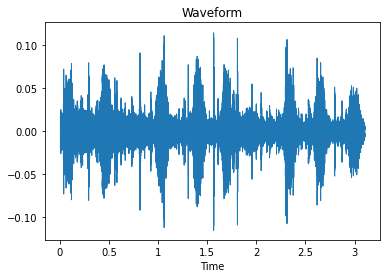

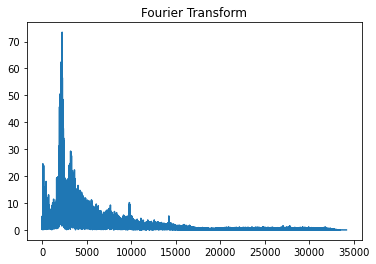

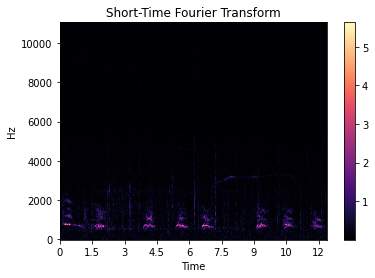

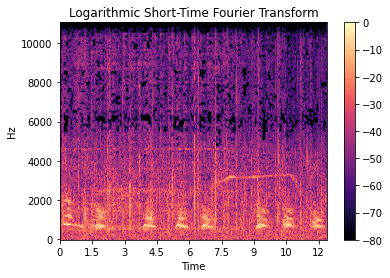

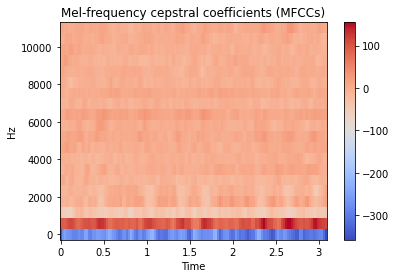

In [100]:
# Pick a row to visualize the datum
row_ind = 100

row = metadata.loc[row_ind]
visualize_data(row)

There are 374 gun_shot sounds, 4% of total sounds.


array([[<AxesSubplot:title={'center':'fold'}>]], dtype=object)

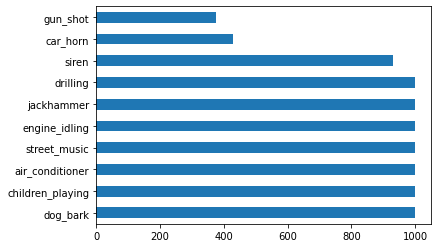

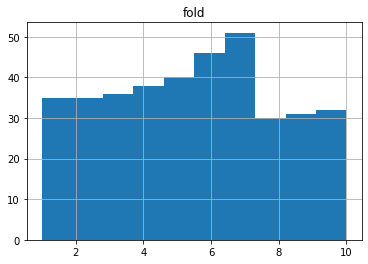

In [9]:
# Checking if we have a decent number of gun_shot sounds, and if they're distributed among the folds

counts = metadata['class'].value_counts()
print(f'There are {counts["gun_shot"]} gun_shot sounds, {round(100*(counts["gun_shot"]/sum(counts)))}% of total sounds.')

counts.plot(kind='barh')

metadata_gun_shot = metadata[metadata['class']=='gun_shot']
metadata_gun_shot.hist(column='fold')


Class: gun_shot
Duration: 2.612s
Salience: foreground


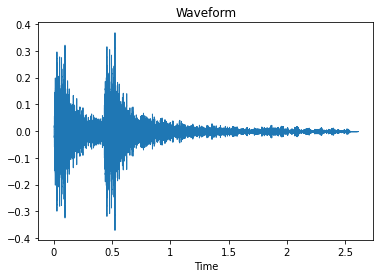

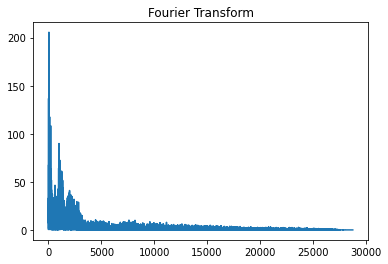

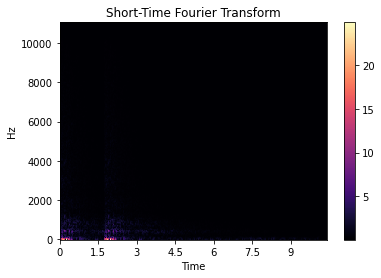

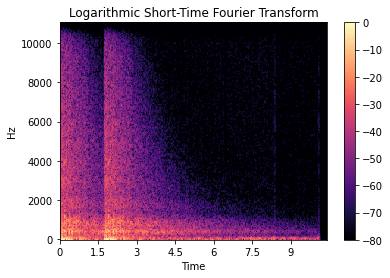

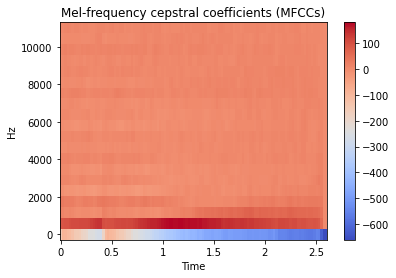

In [102]:
# Visualize specifically a gun_shot datum
row_ind = 0
visualize_data(metadata_gun_shot.iloc[row_ind])